In [1]:
import os
from pathlib import Path
import cv2
import numpy as np
from matplotlib import pyplot as plt
from skimage import io
from skimage import img_as_ubyte
from skimage import exposure

import concurrent.futures

In [2]:
def rotate_bound(image, angle):
    # grab the dimensions of the image and then determine the
    # center
    (h, w) = image.shape[:2]
    (cX, cY) = (w // 2, h // 2)
    # grab the rotation matrix (applying the negative of the
    # angle to rotate clockwise), then grab the sine and cosine
    # (i.e., the rotation components of the matrix)
    M = cv2.getRotationMatrix2D((cX, cY), -angle, 1.0)
    cos = np.abs(M[0, 0])
    sin = np.abs(M[0, 1])
    # compute the new bounding dimensions of the image
    nW = int((h * sin) + (w * cos))
    nH = int((h * cos) + (w * sin))
    # adjust the rotation matrix to take into account translation
    M[0, 2] += (nW / 2) - cX
    M[1, 2] += (nH / 2) - cY
    # perform the actual rotation and return the image
    return cv2.warpAffine(image, M, (nW, nH))

In [3]:
def filter_vessels(thresh, target_img):
    # Find laplace
    ddepth = cv2.CV_16S
    kernel_size = 1
    dst = cv2.Laplacian(target_img, ddepth, ksize=kernel_size)
    abs_dst = cv2.convertScaleAbs(dst)
     
    # Find vars for pixel search
    rows,cols = abs_dst.shape
    midy = np.floor(rows / 2)
    midx = np.floor(cols / 2)
    
    # Init search vars
    mask = np.zeros(abs_dst.shape)
    mask = cv2.convertScaleAbs(mask)
    processed = np.zeros(abs_dst.shape)

    # Pixel search
    toprocess = [[int(midy),int(midx)]]
    while len(toprocess) > 0:
        # Get current
        coord = toprocess.pop(0)
        mask[coord[0]][coord[1]] = 255
        processed[coord[0]][coord[1]] = 1
    
        # Find adjacent pixels
        adjacent = []
        if coord[0] != 0:
            adjacent.append([coord[0] - 1, coord[1]])
        if coord[0] != rows - 1:
            adjacent.append([coord[0] + 1, coord[1]])
        if coord[1] != 0:
            adjacent.append([coord[0], coord[1] - 1])
        if coord[1] != cols - 1:
            adjacent.append([coord[0], coord[1] + 1])
        
        # See if they should be added
        for i in range(len(adjacent)):        
            test_coord = adjacent[i]
      
            if processed[test_coord[0]][test_coord[1]] != 1:           
                val = abs_dst[test_coord[0]][test_coord[1]]
                if val != 0 and val <= thresh:
                    processed[test_coord[0]][test_coord[1]] = 1
                    toprocess.append(test_coord)

    # Mask original
    final_img = cv2.bitwise_and(mask,target_img)
    
    return final_img


In [4]:
mask_path = '../data'
frames_path = '../data/tif'
output_path = '../data/auto_seg_tiff'

In [5]:
frame_count = 1100

angle_increment = 2
min_angle = 10
max_angle = 80

blur_amount = 7
vessel_thresh = 200

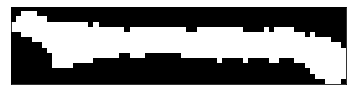

In [6]:
img_mask = cv2.imread(os.path.join(mask_path,'mask-1-cropped.jpg'),0)
ret, img_mask = cv2.threshold(img_mask, 10, 255, cv2.THRESH_BINARY)

plt.figure()
plt.xticks([]),plt.yticks([])
plt.imshow(img_mask,'gray')
plt.show()

In [7]:
# sample_id = "s_12_z_1"
# tiff_path = os.path.join(frames_path, "fid - DCE_FLASH_1.28ms (E9) _s_12_z_1.tif")

sample_id = "s_24_z_1"
tiff_path = os.path.join(frames_path, "fid - DCE_FLASH_1.28ms (E9) _s_24_z_1.tif")

tiff_image = io.MultiImage(tiff_path)

In [8]:
Path(os.path.join(output_path,sample_id,"frames")).mkdir(parents=True, exist_ok=True)
Path(os.path.join(output_path,sample_id,"masks")).mkdir(parents=True, exist_ok=True)
Path(os.path.join(output_path,sample_id,"unfilt_crops")).mkdir(parents=True, exist_ok=True)
Path(os.path.join(output_path,sample_id,"crops")).mkdir(parents=True, exist_ok=True)
Path(os.path.join(output_path,sample_id,"real_masks")).mkdir(parents=True, exist_ok=True)

In [9]:
def find_mask(frame_no):
    # Get file name
    file_name = "frame-%d.jpg" % frame_no
    
    # Open image and pre-process
    #img_orig = cv2.imread(os.path.join(frames_path,file_name),0)
    gamma_corrected = exposure.adjust_gamma(tiff_image[frame_no], 2)
    img_orig = img_as_ubyte(gamma_corrected)
    #img_temp = np.zeros(img_orig.shape)
    #img_norm = cv2.normalize(img_orig, img_temp, 0, 255, cv2.NORM_MINMAX)
    
    img_blur = cv2.medianBlur(img_orig, blur_amount)
    img_thresh = cv2.adaptiveThreshold(img_blur,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,11,2)
    img_thresh_inv = cv2.bitwise_not(img_thresh)
    
    # Init variables
    angle = min_angle
    images = []
    scores = []
    positions = []
    rows,cols = img_orig.shape
    
    # Log
    #print("Frame {0} has {1} rows and {2} cols".format(i,rows,cols))
    
    while angle <= max_angle:
    
        # Rotate mask and log
        img_mask_rotated = rotate_bound(img_mask, angle)
        ret, img_mask_rotated = cv2.threshold(img_mask_rotated, 1, 255, cv2.THRESH_BINARY)
        mask_rows,mask_cols = img_mask_rotated.shape
        #print("Current rotation {2} degrees has {0} rows and {1} cols".format(mask_rows,mask_cols,angle))
    
        # Pass image over
        for i in range(rows):
            if i + mask_rows > rows:
                continue
            for j in range(cols):
                if j + mask_cols > cols:
                    continue
            
                # Create roi
                roi = img_thresh_inv[i:mask_rows+i,j:mask_cols+j]

                # Mask with mask
                masked = cv2.bitwise_and(roi,img_mask_rotated)
            
                # Save image and scores
                images.append(masked)
                scores.append(masked.sum())
                positions.append([i,j,angle])
            
        angle += angle_increment
    
    max_score = np.max(scores)
    max_index = np.argmax(scores)
    best_position = positions[max_index]
    
    # Reload the best mask
    img_mask_rotated = rotate_bound(img_mask, best_position[2])
    ret, img_mask_rotated = cv2.threshold(img_mask_rotated, 1, 255, cv2.THRESH_BINARY)
    mask_rows,mask_cols = img_mask_rotated.shape
    
    # Output mask in a full sized image
    final_mask = np.zeros(img_orig.shape)
    final_mask[best_position[0]:mask_rows+best_position[0],best_position[1]:mask_cols+best_position[1]] = img_mask_rotated
    
    # Create final roi based on cropped mask
    roi1 = img_orig[best_position[0]:mask_rows+best_position[0],best_position[1]:mask_cols+best_position[1]]
    masked_orig = cv2.bitwise_and(roi1,img_mask_rotated)
    
    # Normalise final crop ignoring zeroes
    minval = np.min(masked_orig[np.nonzero(masked_orig)])
    maxval = np.max(masked_orig[np.nonzero(masked_orig)])
    masked_norm = masked_orig
    masked_norm[np.nonzero(masked_orig)] = ((masked_orig[np.nonzero(masked_orig)] - minval) / (maxval - minval)) * 255
    
    # Filter out blood vessels around the bone
    final_masked = filter_vessels(vessel_thresh, masked_norm)
    
    # Create large image with cropped real image in it
    final_mask_orig = np.zeros(img_orig.shape)
    final_mask_orig[best_position[0]:mask_rows+best_position[0],best_position[1]:mask_cols+best_position[1]] = final_masked
    
    # Save mask and frame to file
    frame_name = "frame-%d.png" % frame_no
    mask_name = "mask-%d.png" % frame_no
    crop_name = "crop-%d.png" % frame_no
    real_name = "real-%d.png" % frame_no
    
    if frame_no == 0:
        plt.figure()
        plt.xticks([]),plt.yticks([])
        plt.imshow(img_orig,'gray')
        plt.show()
        
        plt.figure()
        plt.xticks([]),plt.yticks([])
        plt.imshow(img_blur,'gray')
        plt.show()
        
        plt.figure()
        plt.xticks([]),plt.yticks([])
        plt.imshow(img_thresh_inv,'gray')
        plt.show()
        
        plt.figure()
        plt.xticks([]),plt.yticks([])
        plt.imshow(masked_norm,'gray')
        plt.show()
        
        plt.figure()
        plt.xticks([]),plt.yticks([])
        plt.imshow(final_masked,'gray')
        plt.show()
    
    cv2.imwrite(os.path.join(output_path,sample_id,"frames",frame_name), img_orig)
    cv2.imwrite(os.path.join(output_path,sample_id,"masks",mask_name), final_mask)
    cv2.imwrite(os.path.join(output_path,sample_id,"unfilt_crops",crop_name), masked_norm) 
    cv2.imwrite(os.path.join(output_path,sample_id,"crops",crop_name), final_masked) 
    cv2.imwrite(os.path.join(output_path,sample_id,"real_masks",real_name), final_mask_orig)
    
    #print("Frame {0}: MS={1} BP-X:{2} BP-Y:{3} BP-A:{4}".format(frame_no,max_score,best_position[0],best_position[1],best_position[2]))    
    return [frame_no,max_score,best_position[0],best_position[1],best_position[2]]

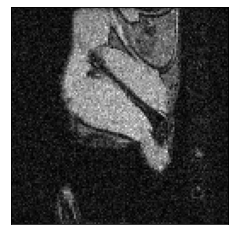

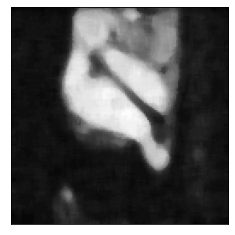

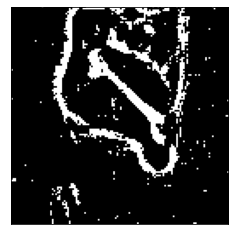

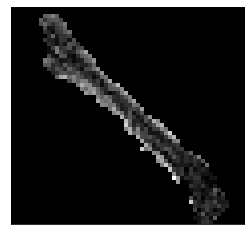

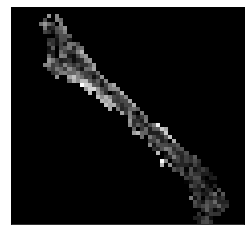

Frame 0: MS=91545 BP-X:23 BP-Y:38 BP-A:42


In [10]:
results = []
for frame_no in range(frame_count):
    result = find_mask(frame_no)
    print("Frame {0}: MS={1} BP-X:{2} BP-Y:{3} BP-A:{4}".format(result[0],result[1],result[2],result[3],result[4]))
    break

In [11]:
#run mult-threaded
# results = []
# frame_range = range(frame_count)
# with concurrent.futures.ProcessPoolExecutor() as executor:
#     futures = [executor.submit(find_mask, frame_no) for frame_no in frame_range]
    
#     for future in concurrent.futures.as_completed(futures):
#         result = future.result()
#         results.append(result)
#         print("Frame {0}: MS={1} BP-X:{2} BP-Y:{3} BP-A:{4}".format(result[0],result[1],result[2],result[3],result[4]))

In [12]:
#print(results)
np.savetxt(os.path.join(output_path,sample_id,"summary.csv"),results, header="frame_no,score,xpos,ypos,angle",delimiter=",")